## Machine Learning Accelerator Computer Vision - Final Project - Day 2

In this project, you will train Convolutional Neural Networks to correctly classify images of luggages. The competition is hosted here: https://leaderboard.corp.amazon.com/tasks/312

We have a total of 5 classes and they are:
* Class 0: Inconclusive
* Class 1: Two wheels
* Class 2: Four wheels
* Class 3: Not a luggage
* Class 4: Zero wheels

__Today, we talked about more advanced pre-trained networks. You can try to use pretrained a AlexNet model. MLA-CV-DAY2-AlexNet.ipynb will help you__

Installing the required mxnet version below.

In [1]:
! pip install -q -U mxnet-cu101mkl==1.6.0.post0  # updating mxnet to at least v1.6
! pip install -q d2l

### 1. Reading the dataset and creating loaders:

Your final project dataset is stored under the __"final_project_dataset"__ folder. Over there you will see the __training__, __validation__ and __test__ folders. Let's start creating the data transforms and loaders below. In this project, images come in different sizes and we will resize them to 224x224.

In [2]:
# import the datasets
import boto3
import os
from os import path
import pandas as pd
import zipfile

bucketname = 'mlu-courses-datalake'
filename = 'MLA-CV/data/final_project_dataset.zip'

pathname = '../../data/'
s3 = boto3.resource('s3')
if not path.exists("../../data/"):
    try:
        os.makedirs(pathname)
    except OSError:
        print ("Creation of the directory %s failed" % pathname)

s3.Bucket(bucketname).download_file(filename , '../../data/final_project_dataset.zip')

print ("Successfully created the directory %s " % pathname)

Successfully created the directory ../../data/ 


In [3]:
zipdata = zipfile.ZipFile('../../data/final_project_dataset.zip')
zipdata.extractall('../../data')
!rm ../../data/final_project_dataset.zip

In [4]:
import os
from d2l import mxnet as d2l
import mxnet as mx
from mxnet.image import imread, imresize
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
from sklearn.metrics import accuracy_score

transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

batch_size = 16

path = '../../data/final_project_dataset'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'validate')
test_path = os.path.join(path, 'test')

train_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True)

validation_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False)

Let's see some pictures.

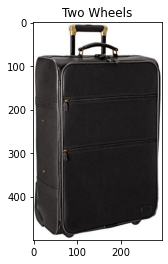

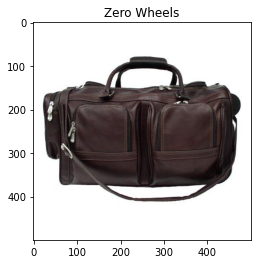

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

im1 = imread(train_path + "/class_1/B003AOIJ74.jpg")
im2 = imread(train_path + "/class_4/B002GQRGOY.jpg")

plt.imshow(im1.asnumpy())
plt.title("Two Wheels")
plt.show()
plt.imshow(im2.asnumpy())
plt.title("Zero Wheels")
plt.show()

### 2. Training and Validation

In this part, you will use a simple Convolutional Neural Network. You can start with a network that we discuss in the class today. You will use the __train_loader__ and __validation_loader__ from above. 

Some important notes:
* There are 5 classes in this project, so adjust the network's last dense layer for that
* Once the tranining runs without errors, experiment with batch_size (in the data loaders part) and learning rate in your code. 

In [7]:
## Build and train/validate your CNN here
## define the fine_Tuned Alexnet
def FineTuneAlexnet(classes, ctx):
    '''
    classes: number of the output classes 
    ctx: training context (CPU or GPU)
    '''
    finetune_net = gluon.model_zoo.vision.alexnet(classes=classes, pretrained=False, ctx=ctx)
    finetune_net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
    pretrained_net = gluon.model_zoo.vision.alexnet(pretrained=True, ctx=ctx)
    finetune_net.features = pretrained_net.features
    
    return finetune_net

#call fineTuneAlexnet to create net
ctx = mx.gpu() # Set this to CPU or GPU depending on your training instance
epochs = 15
learning_rate = 0.002
num_outputs = 5 # 5 output classes
net = FineTuneAlexnet(num_outputs, ctx)
net



AlexNet(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), Activation(relu))
    (1): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (2): Conv2D(64 -> 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), Activation(relu))
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (4): Conv2D(192 -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (5): Conv2D(384 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (6): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (7): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (8): Flatten
    (9): Dense(9216 -> 4096, Activation(relu))
    (10): Dropout(p = 0.5, axes

In [8]:
#define loss function and training rate
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})

#define accuracy function
def finetune_accuracy(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) == label.astype('float32')).mean()

# Starting the outer loop, we will have 10 epochs (10 full pass through our dataset)
for epoch in range(epochs):
    
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    for i, (data, label) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_etropy_loss(output, label)
        loss.backward()
        train_acc += finetune_accuracy(output, label)
        train_loss += loss.mean()
        trainer.step(data.shape[0])
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    for i, (data, label) in enumerate(validation_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        valid_acc += finetune_accuracy(output, label)
        val_loss += softmax_cross_etropy_loss(output, label).mean()
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch, train_loss.asnumpy()[0], train_acc.asnumpy()[0], val_loss.asnumpy()[0], valid_acc.asnumpy()[0]))

Epoch 0: train loss 1.135, train acc 0.574, val loss 0.745, val acc 0.697
Epoch 1: train loss 0.787, train acc 0.702, val loss 0.695, val acc 0.724
Epoch 2: train loss 0.681, train acc 0.737, val loss 0.627, val acc 0.745
Epoch 3: train loss 0.607, train acc 0.769, val loss 0.601, val acc 0.779
Epoch 4: train loss 0.550, train acc 0.793, val loss 0.596, val acc 0.744
Epoch 5: train loss 0.497, train acc 0.814, val loss 0.612, val acc 0.739
Epoch 6: train loss 0.458, train acc 0.829, val loss 0.559, val acc 0.776
Epoch 7: train loss 0.431, train acc 0.848, val loss 0.540, val acc 0.801
Epoch 8: train loss 0.406, train acc 0.852, val loss 0.527, val acc 0.786
Epoch 9: train loss 0.350, train acc 0.872, val loss 0.536, val acc 0.771
Epoch 10: train loss 0.334, train acc 0.876, val loss 0.533, val acc 0.809
Epoch 11: train loss 0.318, train acc 0.885, val loss 0.527, val acc 0.786
Epoch 12: train loss 0.281, train acc 0.892, val loss 0.582, val acc 0.783
Epoch 13: train loss 0.261, train a

### 3. Reading the test data and getting predictions

After you trained your model, it is time to read our test set and make predictions with it. Then, we will write our predictions to a csv file that thas "ID" and "label" columns. This will be our final project submission file.

In [9]:
import pandas as pd

test_df = pd.read_csv("../../data/final_project_dataset/public_test_features.csv")
print(test_df.head())

     ID        ASIN
0  1453  B00M8TTDM2
1   655  B005544142
2  1178  B00TKFGAEQ
3   548  B07G9YMP3R
4  1547  B0198M4NHQ


Let's read these files

In [10]:
test_ids = test_df["ID"].values.tolist()
test_image_files = [file + ".jpg" for file in test_df["ASIN"].values.tolist()]

We resize the images to the same size as in the training/validation (224x224).

In [11]:
test_images = nd.zeros((len(os.listdir(test_path)), 224, 224, 3))
for idx, im_name in enumerate(test_image_files):
    test_images[idx] = imresize(imread(os.path.join(test_path, im_name)), 224, 224)

# make sure shuffle=False
test_loader = gluon.data.DataLoader(
    transform_test(test_images),
    batch_size=batch_size, shuffle=False)

Let's get the predictions.

In [12]:
ctx = mx.gpu() # Set this to CPU or GPU depending on your training instance
test_preds = []
for i, data in enumerate(test_loader):
    data = data.as_in_context(ctx)
    pred = net(data)
    test_preds += pred.argmax(axis=1).asnumpy().tolist()
print(test_preds)

[4.0, 4.0, 4.0, 1.0, 2.0, 1.0, 0.0, 4.0, 4.0, 1.0, 2.0, 4.0, 2.0, 1.0, 1.0, 1.0, 4.0, 1.0, 4.0, 1.0, 1.0, 4.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 4.0, 2.0, 1.0, 2.0, 2.0, 1.0, 3.0, 1.0, 1.0, 4.0, 2.0, 4.0, 1.0, 2.0, 2.0, 1.0, 2.0, 4.0, 1.0, 4.0, 1.0, 2.0, 1.0, 1.0, 4.0, 2.0, 2.0, 1.0, 1.0, 4.0, 1.0, 4.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 4.0, 2.0, 4.0, 1.0, 4.0, 4.0, 1.0, 1.0, 1.0, 2.0, 4.0, 2.0, 1.0, 4.0, 4.0, 4.0, 1.0, 1.0, 2.0, 4.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 4.0, 1.0, 1.0, 4.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 4.0, 1.0, 4.0, 1.0, 2.0, 4.0, 2.0, 0.0, 1.0, 1.0, 2.0, 4.0, 2.0, 1.0, 4.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 3.0, 4.0, 2.0, 4.0, 4.0, 1.0, 4.0, 3.0, 4.0, 1.0, 1.0, 1.0, 2.0, 1.0, 4.0, 4.0, 1.0, 4.0, 2.0, 2.0, 0.0, 2.0, 2.0, 4.0, 4.0, 3.0, 2.0, 0.0, 1.0, 2.0, 4.0, 1.0, 2.0, 1.0, 1.0, 4.0, 4.0, 2.0, 4.0, 4.0, 2.0, 1.0, 1.0, 4.0, 4.0, 1.0, 1.0, 1.0, 1.0,

## 4. Submit your predictions

This is the last step. The code block below will create a csv file: __final_project.csv__ with ID and label (your predictions) columns and then you will submit it to the leaderboard: https://leaderboard.corp.amazon.com/tasks/312/submit

In [13]:
import pandas as pd

test_subm_df = pd.DataFrame({"ID": test_ids,
                             "label": test_preds})

test_subm_df.to_csv("final_project.csv", index=False)